In [13]:
import sys

sys.path.append("../")
import pandas as pd
from matplotlib import pyplot as plt

from processing.sanitization import get_sample_data
from processing.devices import BRYMEN_BM811_CURRENT, BRYMEN_BM811_VOLTAGE
from processing.linear_regression import get_regression, LinearRegressionData
from processing.uncertainty import compute_uncertainty
from typing import Optional

In [14]:
from typing import List


def prepare_data(path: str, sort_ascending: Optional[bool] = True) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=False, header=0)
    df.sort_values(by="U", ascending=sort_ascending)

    df["u(U)"] = [compute_uncertainty(v, BRYMEN_BM811_VOLTAGE) for v in df["U"]]
    df["u(I)"] = [compute_uncertainty(i, BRYMEN_BM811_CURRENT) for i in df["I"]]

    return df


def merge_data(path_1: str, path_2: str) -> pd.DataFrame:
    df1 = prepare_data(path_1)
    df2 = prepare_data(path_2)
    df_result = pd.concat([df1, df2])

    df_result.sort_values(by="U", inplace=True)
    df_result.drop(df_result.tail(10).index, inplace=True)
    df_result.drop(df_result.head(10).index, inplace=True)

    df_result.to_csv("out.csv")

    return df_result


def plot_zener_with_regression(
    df: pd.DataFrame, forward_sample: int, reverse_sample: int
) -> List[LinearRegressionData]:
    forward_regr_voltage = df["U"][-reverse_sample:].to_numpy()
    forward_regr_current = df["I"][-reverse_sample:].to_numpy()

    reverse_regr_voltage = df["U"][:forward_sample].to_numpy()
    reverse_regr_current = df["I"][:forward_sample].to_numpy()

    forward_data, forward_vals, forward_model = get_regression(
        forward_regr_voltage, forward_regr_current
    )
    reverse_data, reverse_vals, reverse_model = get_regression(
        reverse_regr_voltage, reverse_regr_current
    )

    plt.figure()
    plt.grid()
    plt.xlabel("U[mV]")
    plt.ylabel("I[mA]")
    plt.errorbar(
        df["U"], df["I"], xerr=df["u(U)"], yerr=df["u(I)"], zorder=-1, ls="None"
    )
    plt.scatter(df["U"], df["I"], zorder=-1, ls="None", s=2)
    plt.plot(forward_vals, forward_model.predict(forward_vals), color="red")
    plt.plot(reverse_vals, reverse_model.predict(reverse_vals), color="orange")
    plt.show()

    return [forward_data, reverse_data]


def plot_with_regression(df: pd.DataFrame) -> LinearRegressionData:
    regr_voltage = df["U"][-30:].to_numpy()
    regr_current = df["I"][-30:].to_numpy()

    data, vals, model = get_regression(regr_voltage, regr_current)

    plt.figure()
    plt.grid()
    plt.xlabel("U[V]")
    plt.ylabel("I[A]")

    plt.errorbar(
        df["U"], df["I"], xerr=df["u(U)"], yerr=df["u(I)"], zorder=-1, ls="None"
    )
    plt.scatter(df["U"], df["I"], zorder=-1, ls="None", s=2)

    plt.plot(vals, model.predict(vals), color="orange")
    plt.plot(vals, model.predict(vals), color="orange")

    plt.show()

    return data


def sample_data_presentation(df_1: pd.DataFrame, df_2: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df_1[0:40], df_2[0:40]], axis=1)


def styled_latex_output(df: pd.DataFrame) -> str:
    latex = df.to_latex(index=False, header=True, escape=False)

    # Define header styling
    header = r"\rowcolor{lightgray}"

    # Add header styling to first row of LaTeX output
    latex = latex.split("\n")
    latex[0] = header + latex[0]
    latex = "\n".join(latex)

    # Add multirow and booktabs packages to LaTeX output preamble
    preamble = r"""
    \usepackage{multirow}
    \usepackage{booktabs}
    \usepackage[table]{xcolor}
    \definecolor{lightgray}{gray}{0.9}
    \setlength{\aboverulesep}{0pt}
    \setlength{\belowrulesep}{0pt}
    \setlength{\extrarowheight}{1pt}
    """
    latex = latex.replace(
        "\\begin{tabular}", "\\begin{tabular}{>{\\rule{0pt}{2.5ex}}ll}"
    )

    # Add colortbl package to LaTeX output and define table border
    latex = latex.replace("\\begin{tabular}{", "\\begin{tabular}{|l|l|}")
    latex = (
        "\\begin{tabular}{|l|l|}\n\\hline\n" + latex.split("\\begin{tabular}{|l|l|}")[1]
    )
    latex = latex.split("\\end{tabular}")[0] + "\\hline\n\\end{tabular}"

    # Combine preamble and table
    return preamble + "\n" + latex

# Rectifying

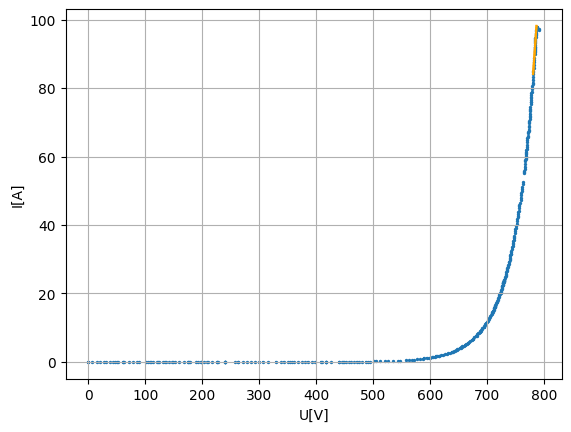

a=2.341667016347249 b=-1744.7252745628357


/Users/igorkrzywda/opt/anaconda3/envs/data/lib/python3.11/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 2 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


,U,I,u(U),u(I)
0,0,-0.01,0.012,0.00023
1,190,-0.01,0.140,0.00023
2,390,0.00,0.280,0.00023
3,590,1.10,0.420,0.00036
4,680,6.60,0.480,0.00099
5,710,16.00,0.510,0.00210
6,730,22.00,0.520,0.00280
7,750,38.00,0.530,0.00460
8,770,62.00,0.540,0.00740
9,780,82.00,0.550,0.00970


\begin{table}[H]\centering 
 \begin{tabular}{|l|l|l|l|}
\hline
 \rowcolor[HTML]{EFEFEF} 
  U  &   I   &  u(U)  &  u(I)   \\ \hline

  0  & -0.01 & 0.012  & 0.00023 \\ \hline
 190 & -0.01 &  0.14  & 0.00023 \\ \hline
 390 &   0   &  0.28  & 0.00023 \\ \hline
 590 &  1.1  &  0.42  & 0.00036 \\ \hline
 680 &  6.6  &  0.48  & 0.00099 \\ \hline
 710 &  16   &  0.51  & 0.0021  \\ \hline
 730 &  22   &  0.52  & 0.0028  \\ \hline
 750 &  38   &  0.53  & 0.0046  \\ \hline
 770 &  62   &  0.54  & 0.0074  \\ \hline
 780 &  82   &  0.55  & 0.0097  \\ \hline

\end{tabular}
\end{table}


CompletedProcess(args='pbcopy', returncode=0)

In [76]:
from sigfig import round
import subprocess
from tabulate import tabulate
import re


data = prepare_data("data/multimeter_data/sanitized/rectifying.csv")
sample = get_sample_data(data, 40)

linear_regression_coeffs = plot_with_regression(data)

print(linear_regression_coeffs)
rounded = sample.applymap(lambda x: round(x, sigfigs=2))
rounded.reset_index(inplace=True, drop=True)

display(rounded)

# Zener diode 2

,U,I,u(U),u(I),U,I,u(U),u(I)
0,0,-0.010000,0.011547,0.000230,0,-0.010000,0.011547,0.000230
1,851,96.400002,0.601137,0.011362,-2731,-71.699997,1.880545,0.008048
2,21,-0.010000,0.026096,0.000230,-2730,-71.900002,1.879852,0.008071
3,27,-0.010000,0.030253,0.000230,-35,-0.010000,0.012702,0.000230
4,33,-0.010000,0.034410,0.000230,-48,-0.010000,0.021708,0.000230
5,40,-0.010000,0.039260,0.000230,-58,-0.010000,0.028637,0.000230
6,46,-0.010000,0.043417,0.000230,-72,-0.010000,0.038336,0.000230
7,53,-0.010000,0.048266,0.000230,-85,-0.010000,0.047343,0.000230
8,59,-0.010000,0.052423,0.000230,-107,-0.010000,0.062585,0.000230
9,67,-0.010000,0.057966,0.000230,-134,-0.010000,0.081291,0.000230


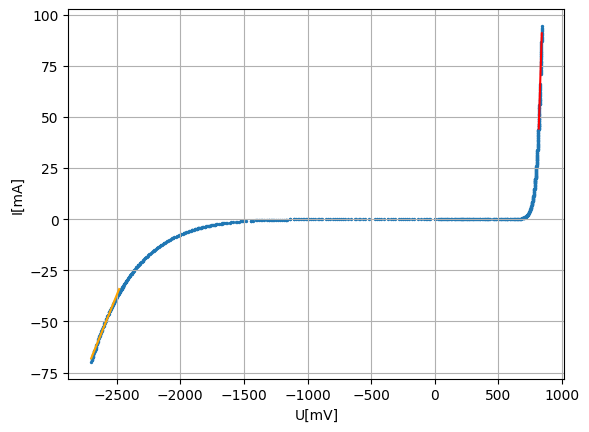

[LinearRegressionData(a=1.9428692555769962, b=-1544.9816677874558), LinearRegressionData(a=0.1540382294375489, b=348.0056482419723)]


In [ ]:
forward = prepare_data("data/multimeter_data/sanitized/zener-p-2.csv")
reverse = prepare_data("data/multimeter_data/sanitized/zener-z-2.csv")

sample = sample_data_presentation(forward, reverse)
display(sample)

data = merge_data(
    "data/multimeter_data/sanitized/zener-p-2.csv",
    "data/multimeter_data/sanitized/zener-z-2.csv",
)
sample = get_sample_data(data, 40)


linear_regression_coeffs = plot_zener_with_regression(data, 100, 100)
print(linear_regression_coeffs)